# Wradlib Attenuation Correction Tutorial
- Hamid Ali Syed

In [1]:
import os
import glob
import numpy as np
import xradar as xd
import xarray as xr
import wradlib as wrl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Glob is used to list the data, so that we have a full paths of these files

In [3]:
files = glob.glob("/Users/syed44/Dual_Doppler_Analysis/data/cfrad*.nc")
len(files)

4

`cfrad*nc` means find all the files in the `out2` directory which starts with `cfrad` and end with `.nc`

In [5]:
# You don't not need this function probably, 
# this is for my data file which I am using in this example

def fix_sitecoords(ds):
    coords = ["longitude", "latitude", "altitude", "altitude_agl"]
    for coord in coords:
        # Compute median excluding NaN
        data = ds[coord].median(skipna=True).item()
        attrs = ds[coord].attrs if coord in ds else {}
        ds = ds.assign_coords({coord: xr.DataArray(data=data, attrs=attrs)})
    return ds

Now if you want to do the attenuation correction using wradlib, you have to use xradar (https://docs.openradarscience.org/projects/xradar/en/stable/usage.html) to read the data

In [5]:
## Read the data
dtree = xd.io.open_cfradial1_datatree(files[0]) # [0] means the first file in a files list.

In [6]:
## Fixing coordinates 
dtree = dtree.xradar.map_over_sweeps(fix_sitecoords)

In [7]:
dtree = dtree.xradar.georeference() # to add x,y, and z to the radar

In [8]:
dtree.groups # see how many sweeps do we have in this data

('/',
 '/sweep_0',
 '/sweep_1',
 '/sweep_2',
 '/sweep_3',
 '/sweep_4',
 '/sweep_5',
 '/sweep_6',
 '/radar_parameters',
 '/georeferencing_correction',
 '/radar_calibration')

In [9]:
dtree['sweep_0'] # to see what is in a sweep_0

<xarray.DataTree 'sweep_0'>
Group: /sweep_0
    Dimensions:                    (sweep: 7, time: 5040, frequency: 1,
                                    azimuth: 720, range: 1180)
    Coordinates:
        altitude_agl               float64 8B nan
        time                       (azimuth) datetime64[ns] 6kB 2022-03-22T22:03:...
      * range                      (range) float32 5kB 87.5 162.4 ... 8.844e+04
      * azimuth                    (azimuth) float32 3kB 0.3 0.8 1.3 ... 359.3 359.8
        elevation                  (azimuth) float32 3kB 0.5096 0.4986 ... 0.4986
        latitude                   float64 8B 32.81
        longitude                  float64 8B -87.95
        altitude                   float64 8B 58.0
        crs_wkt                    int64 8B 0
        x                          (azimuth, range) float64 7MB 0.4581 ... -308.7
        y                          (azimuth, range) float64 7MB 87.49 ... 8.843e+04
        z                          (azimuth, range) float64 7MB 58.78 ... 1.288e+03
    Inherited coordinates:
      * frequency                  (frequency) float32 4B 5.55e+09
    Dimensions without coordinates: sweep
    Data variables: (12/46)
        sweep_number               float64 8B ...
        sweep_mode                 <U20 80B 'azimuth_surveillance'
        prt_mode                   |S32 32B ...
        follow_mode                |S32 32B ...
        sweep_fixed_angle          float32 4B ...
        ray_start_range            (azimuth) float32 3kB ...
        ...                         ...
        RHOHV                      (azimuth, range) float32 3MB ...
        PHIDP                      (azimuth, range) float32 3MB ...
        KDP                        (azimuth, range) float32 3MB ...
        DBZHCC                     (azimuth, range) float32 3MB ...
        DBZHCC_F                   (azimuth, range) float32 3MB ...
        ZDRC                       (azimuth, range) float32 3MB ...

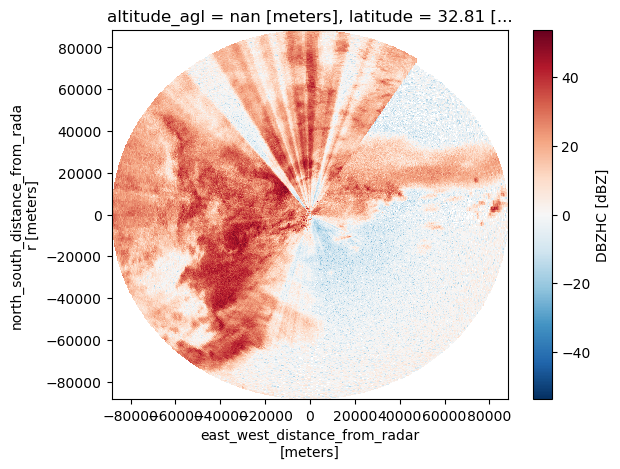

In [10]:
dtree['sweep_0']['DBZHC'].plot(x='x', y='y')

In [11]:
def filter_radar(ds, ref_name='REF'):
    """
    Filter Radar
    
    Parameters
    ----------
    ds: xarray.Dataset
        Radar sweep
    ref_name: str
        Name of the field
    
    Returns
    -------
    xarray.Dataset
    """
    ds = ds.where((ds[ref_name]>-20 ) &
                  (ds[ref_name]<80)
                 )
    return ds

let's try to filter the data as precautionary measure

In [12]:
dtree = dtree.xradar.map_over_sweeps(filter_radar, ref_name='DBZHCC')

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_actual_azimuths_with_indices(dtree, sweep_key, step=10, ax=None, label_offset=1.1):
    """
    Plot azimuth lines based on actual data from a radar DataTree and annotate with azimuth degrees
    and their indices using np.argwhere.

    Parameters
    ----------
    dtree : xarray.Dataset
        Radar dataset containing azimuth data.
    sweep_key : str
        Key for the sweep in the DataTree (e.g., 'sweep_0').
    step : int, optional
        Step size for azimuth selection (default: 10).
    ax : matplotlib.axes.Axes, optional
        Matplotlib axis to plot on. If None, a new figure and axis are created.
    label_offset : float, optional
        Offset factor for label placement relative to max_range (default: 1.1).

    Returns
    -------
    matplotlib.axes.Axes
        The axis with the azimuth lines plotted.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Extract azimuths and range from the dataset
    azimuths = dtree[sweep_key]['azimuth'].azimuth.values  # Actual azimuth degrees
    azi_indices = np.arange(0, len(azimuths))  # Array of azimuth indices
    max_range = dtree[sweep_key]['range'].max().values  # Maximum range of the radar data

    # Select every nth azimuth and its index based on the step
    selected_indices = azi_indices[::step]
    selected_azimuths = azimuths[::step]

    # Convert azimuths to radians, ensuring 0° (North) is at the top
    selected_azimuths_rad = np.radians(90 - selected_azimuths)

    # Plot azimuth lines
    for idx, azimuth_deg, azimuth_rad in zip(selected_indices, selected_azimuths, selected_azimuths_rad):
        x_end = max_range * np.cos(azimuth_rad)
        y_end = max_range * np.sin(azimuth_rad)
        ax.plot([0, x_end], [0, y_end], color='black', linestyle='-', linewidth=2)

        # Annotate with actual degree and index
        x_label = (max_range * label_offset) * np.cos(azimuth_rad)
        y_label = (max_range * label_offset) * np.sin(azimuth_rad)
        ax.text(
            x_label, y_label, f"{int(azimuth_deg)}°\n(idx: {idx})",
            fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.7)
        )

    # Ensure correct orientation and add cardinal labels
    ax.set_xlim(-max_range * label_offset, max_range * label_offset)
    ax.set_ylim(-max_range * label_offset, max_range * label_offset)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])

    # Add cardinal direction labels
    ax.text(0, max_range * 1.2, 'N', ha='center', va='center', fontsize=12, color='black')  # North
    ax.text(max_range * 1.2, 0, 'E', ha='center', va='center', fontsize=12, color='black')  # East
    ax.text(0, -max_range * 1.2, 'S', ha='center', va='center', fontsize=12, color='black') # South
    ax.text(-max_range * 1.2, 0, 'W', ha='center', va='center', fontsize=12, color='black') # West

    return ax

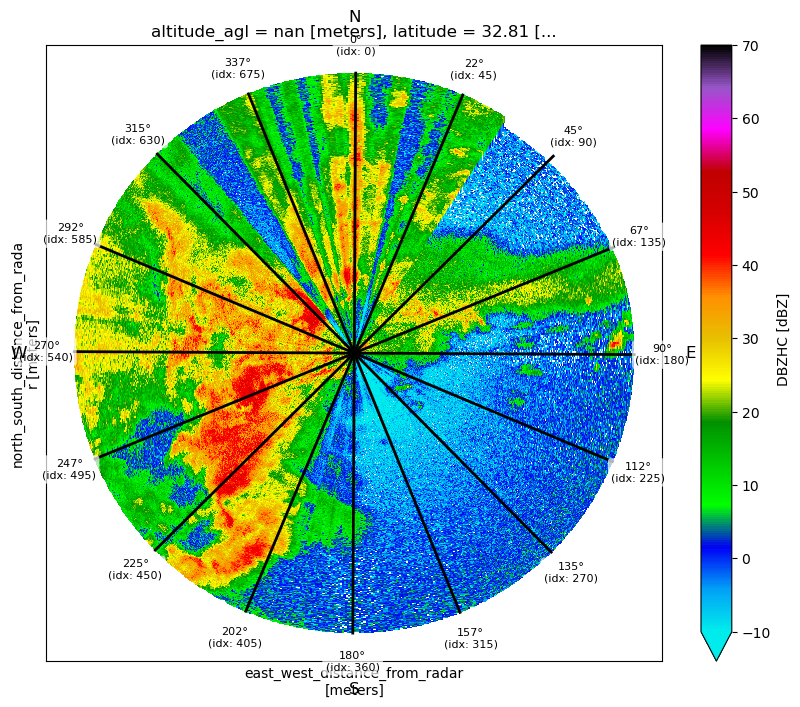

In [14]:
plt.figure(figsize=(10, 8))
ax = plt.axes()
dtree['sweep_0']['DBZHC'].plot(x='x', y='y', vmin=-10, vmax=70, cmap='NWSRef')
plot_actual_azimuths_with_indices(dtree=dtree, sweep_key='sweep_0', step=45, ax=ax )
plt.show()

In the above figure we are plotting every 45th index of array azimuth and labeling it with the azimuth angle and its associated index in the array, let's calculate PIA for the azimuth 225 deg which is at index 450 and few more azimuths around or near it. 

In [15]:
# Let's try to do attenuation correction using Wradlib

In [16]:
data = dtree['sweep_0']['DBZHC'] # using only first sweep, not all

In [17]:
# just a little helper function
def plot_beams(data, mybeams, sub=111):
    ax = fig.add_subplot(sub)
    labelsize = 13
    for beam in range(mybeams.start, mybeams.stop):
        plt.plot(data[beam], label="{0} deg".format(beam))
    plt.grid()
    plt.text(
        0.99,
        0.88,
        "Reflectivity along beams",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize="large",
    )
    plt.xlabel("range (km)", fontsize="large")
    plt.ylabel("Reflectivity (dBZ)", fontsize="large")
    plt.legend(loc="upper left")
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)
    plt.xlim(0, 128)

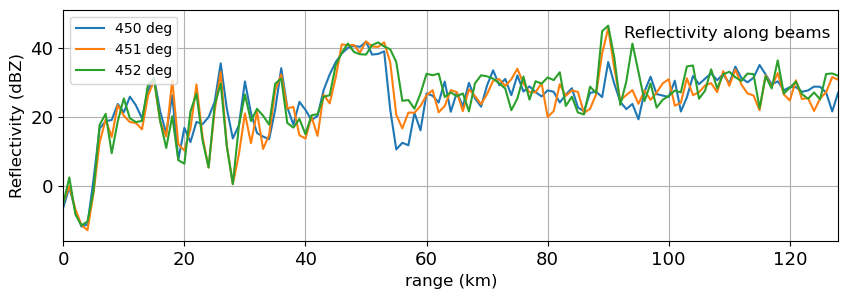

In [18]:
mybeams = slice(450, 453) # azimuths at indices 450 to 453
fig = plt.figure(figsize=(10, 3))
plot_beams(data, mybeams)

In [19]:
pia_hibo = wrl.atten.correct_attenuation_hb(
    data, coefficients=dict(a=8.0e-5, b=0.731, gate_length=1.0), mode="warn", thrs=59.0
)

corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over thr

corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over thr

corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over thr

corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over thr

corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over threshold (59.0)
corrected signal over thr

In [20]:
# another little helper function
def plot_pia(pia, sub=111, title=None):
    ax = fig.add_subplot(sub)
    labelsize = 13
    plt.plot(pia.T)
    plt.grid()
    plt.ylim(0, 30)
    plt.ylabel("PIA (dB)", fontsize="large")
    plt.text(0.01, 0.88, title, transform=ax.transAxes, fontsize="large")
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)
    plt.xlim(0, 128)
    

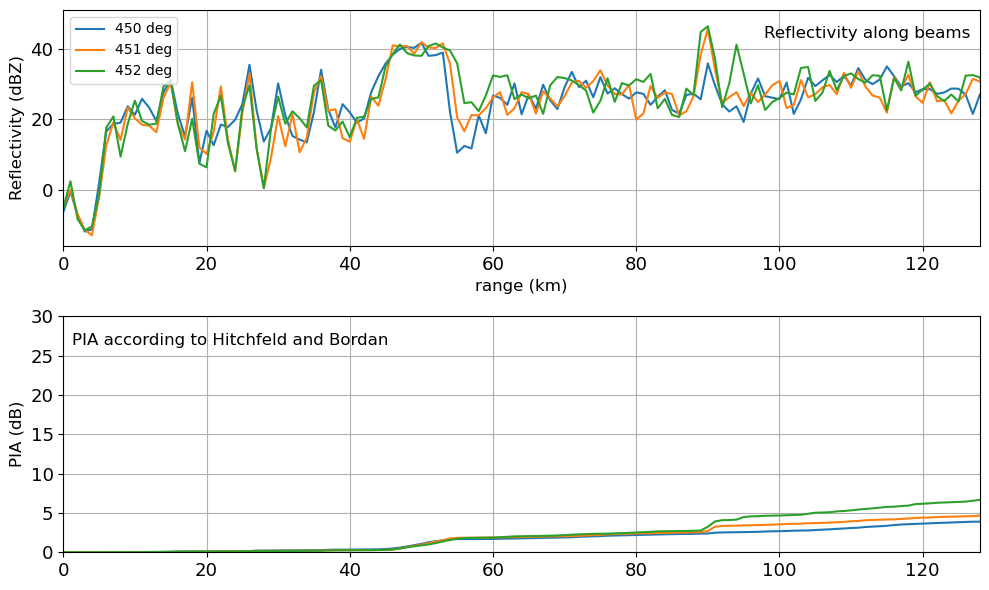

In [21]:
fig = plt.figure(figsize=(10, 6))
plot_beams(data, mybeams, 211)
plot_pia(pia_hibo[mybeams], 212, "PIA according to Hitchfeld and Bordan")
plt.tight_layout()

In [22]:
# Now you can add the PIA to the data so recover the values of the beams which were attenuated

In [23]:
pia_da = xr.DataArray(pia_hibo, dims=data.dims, coords=data.coords)

In [24]:
# Replace NaN and inf/-inf with 0
pia_da = pia_da.where(~np.isnan(pia_da) & ~np.isinf(pia_da), 0)

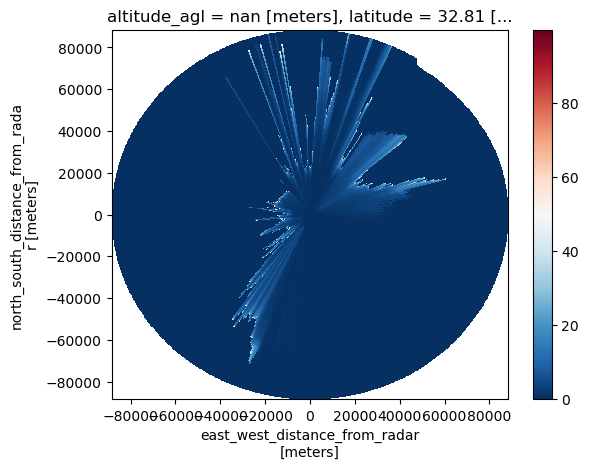

In [30]:
pia_da.where(pia_da<100).plot(x='x', y='y', cmap='RdBu_r')

In [31]:
data_corrected = data + pia_da

In [32]:
data_corrected = data_corrected.where(data_corrected<100)

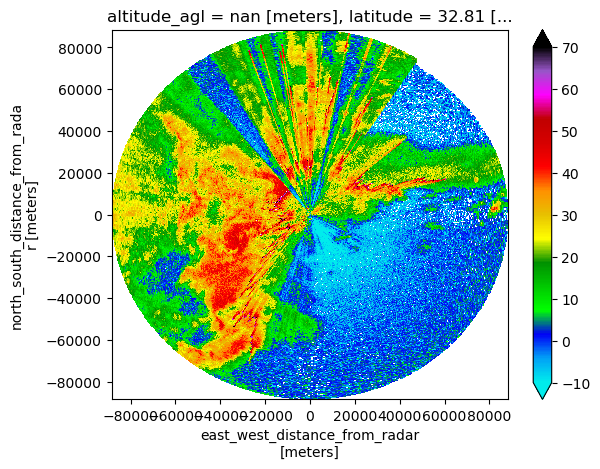

In [33]:
data_corrected.plot(x='x', y='y', cmap='NWSRef', vmin=-10, vmax=70)

In [34]:
## Now let's correct all data

In [45]:
# Define function to apply to whole data
def pia_atten(ds, ref_name = 'REF'):
    data = ds[ref_name]
    pia_hibo = wrl.atten.correct_attenuation_hb(
        data, coefficients=dict(a=8.0e-5, b=0.731, gate_length=1.0), mode="nan", thrs=60)
    
    pia_da = xr.DataArray(pia_hibo, dims=data.dims)
    # Replace NaN and inf/-inf with 0
    pia_da = pia_da.where(~np.isnan(pia_da) & ~np.isinf(pia_da), 0)
    data_corrected = data + pia_da
    data_corrected = data_corrected.where((data_corrected>-20) & (data_corrected<80))
    ds = ds.assign(PIA=pia_da)
    ds = ds.assign(REFC = data_corrected)
    return ds

In [46]:
# Apply to whole data using xradar

In [47]:
dtree2 = dtree.xradar.map_over_sweeps(pia_atten, ref_name='DBZHC')

In [51]:
dtree2 = dtree2.xradar.map_over_sweeps(fix_sitecoords)

In [52]:
dtree2 = dtree2.xradar.georeference()

In [53]:
# Now our data is saved in dtree2 in every sweep as REFC, (`C` for corrected)
# and attenuation values are also in the dataset as PIA

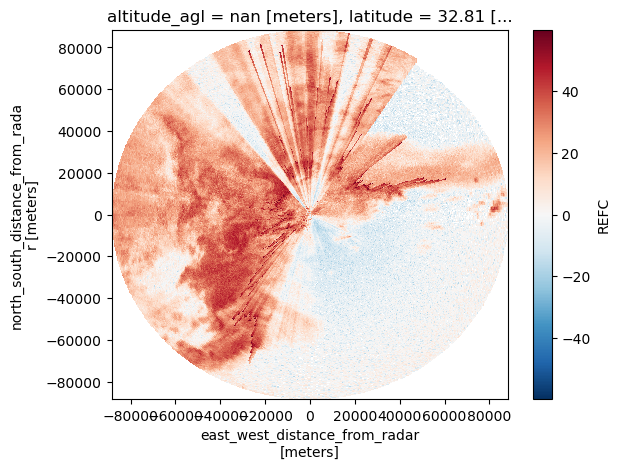

In [54]:
dtree2['sweep_0']['REFC'].plot(x='x', y='y')

In [55]:
## Now Let's apply it to all files and save the data

In [56]:
out_dir = "/Users/syed44/Downloads/Others/XRADAR_EXAMPLES/RADAR_CORRECTED/"
os.makedirs(out_dir, exist_ok=True)

In [57]:
for file in files[:1]: # I am only saving one file here, you have remove this [:1] to process all files.
    print(f"Processing file: {os.path.basename(file)}")
    dtree = xd.io.open_cfradial1_datatree(file)
    dtree = dtree.xradar.map_over_sweeps(pia_atten, ref_name='DBZHC')
    out_file = os.path.basename(file)
    out_path = os.path.join(out_dir, out_file)
    xd.io.to_cfradial1(dtree=dtree, filename=out_path)

Processing file: cfrad.20220322_220338.299_to_20220322_220506.977_COW1high_SUR.nc


## References

- Grover, M., Mühlbauer, K., Goudenhoofdt, E., Syed, H. A., Ladino, A., Jackson, R., & Wolfensberger, D. (2024). openradar/xradar: xradar v0.8.0 (v0.8.0). Zenodo. https://doi.org/10.5281/zenodo.14035347
- Mühlbauer, K., & Heistermann, M. (2024). wradlib/wradlib: wradlib v2.3.0 (2.3.0). Zenodo. https://doi.org/10.5281/zenodo.14045849